In [133]:
from googleapiclient.discovery import build
import pandas as pd
from IPython.display import JSON
from dateutil import parser

#Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#NLP
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Juan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Juan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
api_key = 'youtube_api_key'

In [29]:
channel_ids = ['UCNYW2vfGrUE6R5mIJYzkRyQ',
               # more channels here
              ]

In [30]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [31]:
def get_channel_stats(youtube, channel_ids):
    
        all_data = []
        
        request = youtube.channels().list(
            part="snippet,contentDetails,statistics",
            id=','.join(channel_ids)
        )
        response = request.execute()
        
        for item in response['items']:
            data = {'channelName': item['snippet']['title'],
                    'subscribers': item['statistics']['subscriberCount'],
                    'totalViews' : item['statistics']['viewCount'],
                    'totalVideos': item['statistics']['videoCount'],
                    'playlistId' : item['contentDetails']['relatedPlaylists']['uploads']
                   }
            all_data.append(data)
            
        return(pd.DataFrame(all_data))

In [32]:
channels_stats = get_channel_stats(youtube, channel_ids)

In [33]:
channels_stats

,channelName,subscribers,totalViews,totalVideos,playlistId
0,DrossRotzank,22400000,5671835797,1490,UUNYW2vfGrUE6R5mIJYzkRyQ


In [34]:
playlist_id = 'UUNYW2vfGrUE6R5mIJYzkRyQ'

def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet, contentDetails",
        playlistId=playlist_id,
        maxResults=50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
    
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part="snippet, contentDetails",
                    playlistId=playlist_id,
                    maxResults=50,
                    pageToken =next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        
        next_page_token = response.get('nextPageToken')
    return video_ids



In [35]:
video_ids = get_video_ids(youtube, playlist_id)

In [36]:
def get_video_details(youtube, video_ids):

    all_video_info = []   
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet':['channelTitle','title','description','tags','publishedAt'],
                             'statistics':['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails':['duration','definition','caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None
            all_video_info.append(video_info)
    return(pd.DataFrame(all_video_info))

In [37]:
video_df = get_video_details(youtube, video_ids)

In [38]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,6kcMEzHiCaY,DrossRotzank,El Elevador De Los Perros | Dross,El Elevador De Los Perros | Dross\n\n¡Suscríbe...,"[dross, drossrotzank, horror, terror, miedo, c...",2022-05-14T18:00:02Z,1148723,90323,None,4449,PT12M24S,hd,false
1,o_INb2XsmyI,DrossRotzank,Las Mascotas Que Eran Secuestradas Por La Noch...,Las Mascotas Que Eran Secuestradas Por La Noch...,"[dross, drossrotzank, horror, terror, miedo, c...",2022-05-10T16:47:56Z,1593566,134358,None,22937,PT14M30S,hd,false
2,P0tDrPFcBK4,DrossRotzank,Las 3 Mujeres Más Perversas De Hollywood | Dross,Las 3 Mujeres Más Perversas De Hollywood\n\n¡S...,"[dross, drossrotzank, horror, terror, miedo, c...",2022-05-05T23:07:56Z,2117549,171492,None,9135,PT19M4S,hd,false
3,ItP37iO_dlw,DrossRotzank,3 Misterios Perturbadores De Animales | Dross,3 Misterios Perturbadores De Animales\n\n¡Susc...,"[dross, drossrotzank, horror, terror, miedo, c...",2022-05-01T15:00:14Z,2228310,170122,None,6914,PT12M33S,hd,false
4,bUr8cHdRjlg,DrossRotzank,La Foto Del Marine | Dross,La Foto Del Marine\n\n¡Suscríbete! http://bit....,"[dross, drossrotzank, horror, terror, miedo, c...",2022-04-26T16:00:20Z,1986854,154614,None,5209,PT8M33S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,Pl6y4fZT-Ys,DrossRotzank,Dross juega El Plataformero Injusto,SUSCRÍBETE: http://bit.ly/1a1sm3k\nSÍGUEME EN ...,"[Dross, miedo, dross, fantasmas, terror, paran...",2009-06-06T19:36:04Z,1741394,33218,None,4405,PT10M4S,sd,false
1486,ErafEm2mjQ4,DrossRotzank,Dross juega Syobon Action (Gato Bros),SUSCRÍBETE: http://bit.ly/1a1sm3k\nSÍGUEME EN ...,"[Dross, misterio, Ángel David Revilla, DrossRo...",2009-05-10T16:30:43Z,3369364,131810,None,11208,PT10M1S,sd,false
1487,cKSxwkEe90M,DrossRotzank,Dross juega El Juego Más Difícil del Mundo,SUSCRÍBETE: http://bit.ly/1a1sm3k\nSÍGUEME EN ...,"[the world hardest game, Dross, miedo, dross, ...",2009-04-12T23:51:42Z,3731544,95709,None,8390,PT9M33S,sd,false
1488,KRP-Zq1IOQM,DrossRotzank,Dross Hace Un Review: Aero Fighters,Haz click en http://apps.facebook.com/drossrot...,"[Dross, Ángel David Revilla, longplay, aero fi...",2009-02-23T20:39:18Z,761527,24849,None,2123,PT8M37S,sd,false


## Data Preprocessing

In [39]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags              False
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [42]:
video_df.dtypes

video_id           object
channelTitle       object
title              object
description        object
tags               object
publishedAt        object
viewCount         float64
likeCount         float64
favouriteCount    float64
commentCount      float64
duration           object
definition         object
caption            object
dtype: object

In [50]:
#cambiar el tipo de los valores a numericos

numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [ ]:
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [52]:
# Duracion de los videos en segundos

import isodate

video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [53]:
video_df[['duration','durationSecs']]

,duration,durationSecs
0,PT12M24S,744.0
1,PT14M30S,870.0
2,PT19M4S,1144.0
3,PT12M33S,753.0
4,PT8M33S,513.0
...,...,...
1485,PT10M4S,604.0
1486,PT10M1S,601.0
1487,PT9M33S,573.0
1488,PT8M37S,517.0


In [54]:
# add tag count

video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [55]:
video_df['tagCount']

0       38
1       37
2       36
3       38
4       37
        ..
1485    14
1486    14
1487    15
1488    34
1489    16
Name: tagCount, Length: 1490, dtype: int64

## Visualizacion de datos

### Videos mas vistos

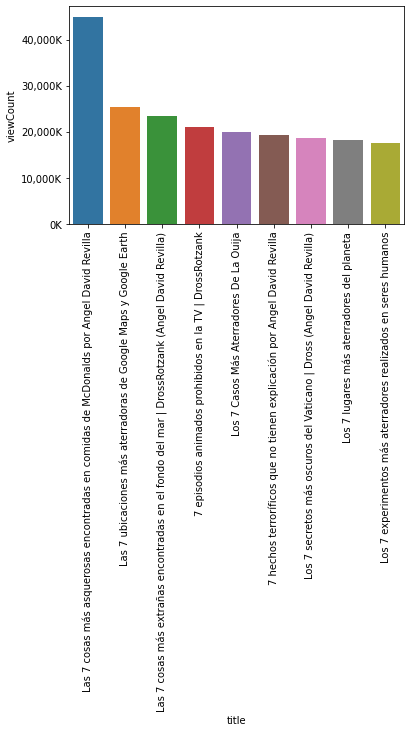

In [113]:
ax = sns.barplot( x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### Videos menos vistos

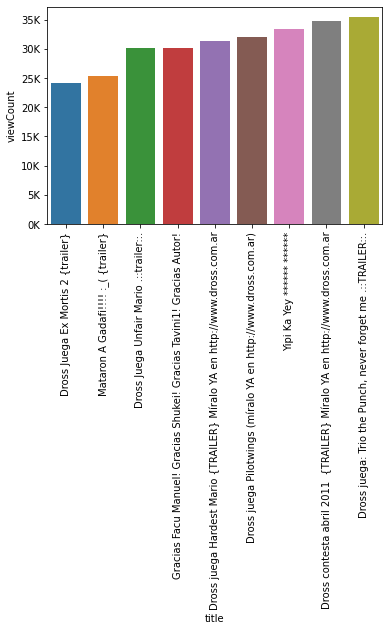

In [114]:
ax = sns.barplot( x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### Distribucion de vistas por video

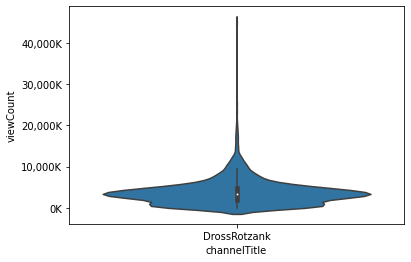

In [112]:
ax = sns.violinplot(data=video_df, x='channelTitle', y='viewCount')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### Vistas vs Comentarios

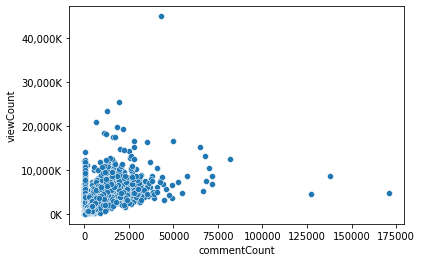

In [106]:
ax = sns.scatterplot(data =video_df, x = 'commentCount', y = 'viewCount')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### Vistas vs Likes

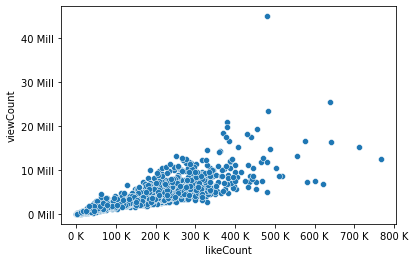

In [111]:
ax = sns.scatterplot( data =video_df, x = 'likeCount', y = 'viewCount')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000000) + ' Mill'))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + ' K'))

### Video duration

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

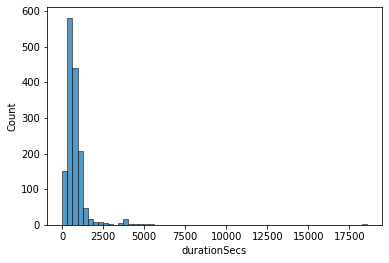

In [122]:
sns.histplot(data = video_df, x='durationSecs', bins=60)

In [ ]:
### Nube de palabras mas 

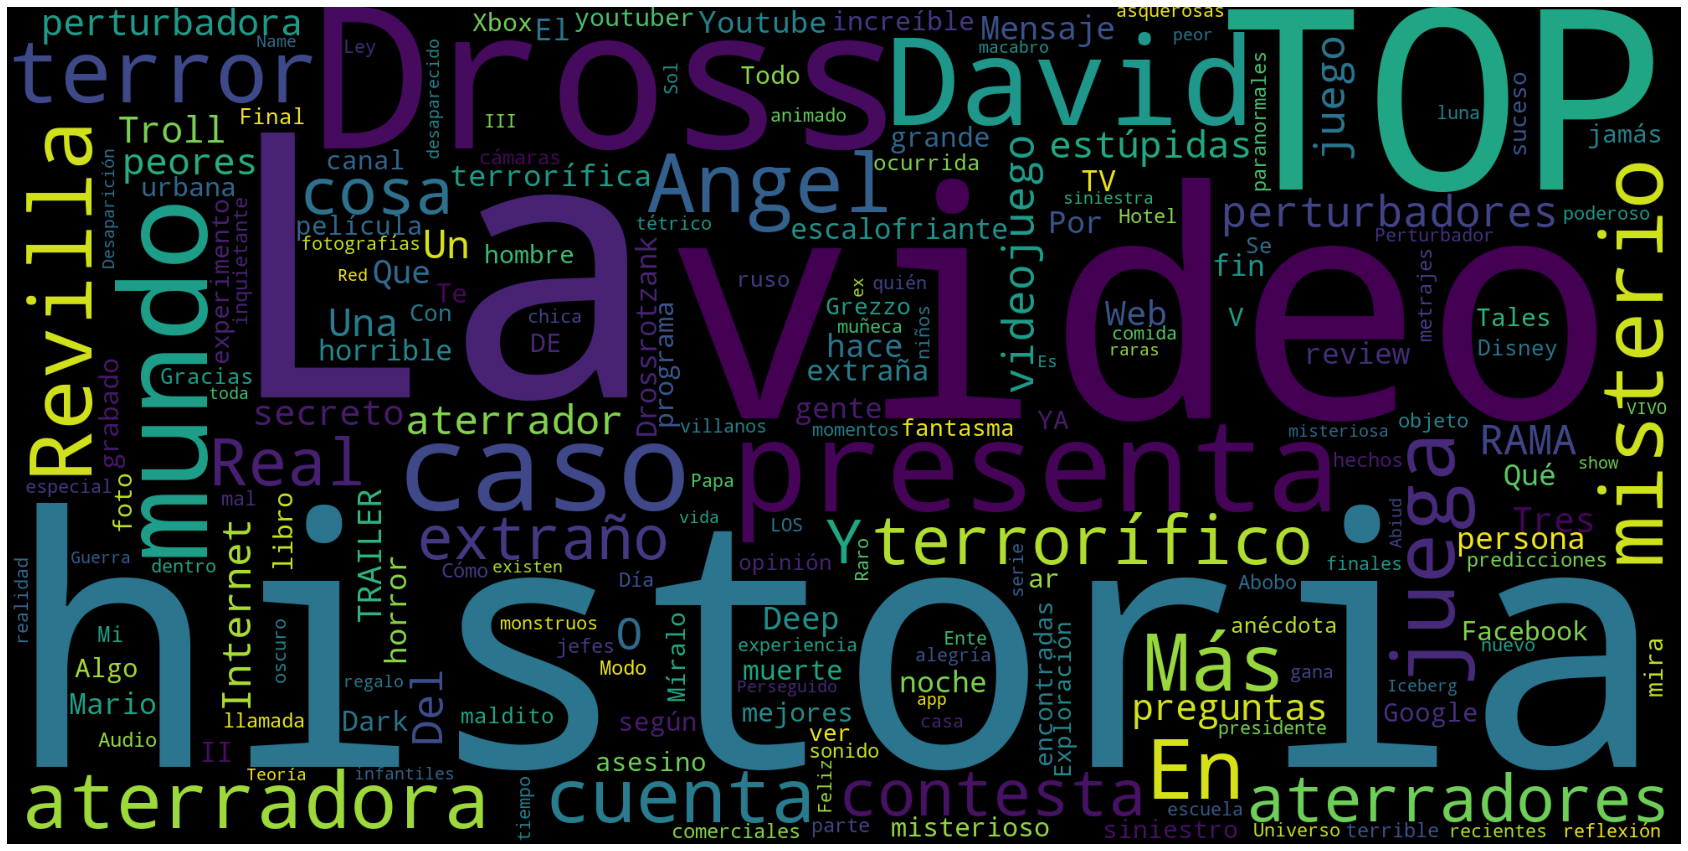

In [142]:
stop_words =stopwords.words('spanish')
newStopWords = ['La','Lo','El','De','Dross','Los','DrossRotzank', 'DROSS']
stop_words.extend(newStopWords)

video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

### Dias que sube videos

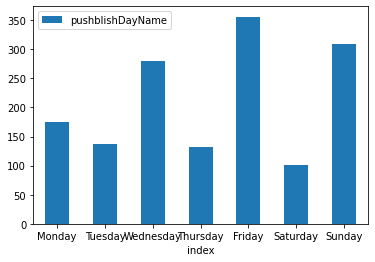

In [153]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)